导入库

In [1]:
import tensorflow as tf
import numpy as np
import mnist_data
import os
# import beta_vae as vae
import vae
import plot_utils
import glob
import random
import matplotlib.pyplot as plt
import cv2

配置参数

In [5]:
#gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#图像尺寸
IMAGE_SIZE_MNIST = 28
#隐变量维度
dim_z=3
#隐层节点数
n_hidden=500
#学习率
learn_rate=1e-3
#训练轮数
n_epochs=50
#批量数目
batch_size=128
#标签样式 one-hot编码
one_hot=np.eye(10)
#结果保存路径
path=os.path.join(os.getcwd(),'result')
if not os.path.exists(path):
    os.system('mkdir '+path)
RESULTS_DIR=path
#是否加入噪声，denoise vae
ADD_NOISE=False
dim_img = IMAGE_SIZE_MNIST**2
#beta-vae
beta=2.0
#画图
PRR=True
PRR_n_img_x=10
PRR_n_img_y=10
PRR_resize_factor=1.0
PMLR=False
PMLR_n_img_x=20
PMLR_n_img_y=20
PMLR_resize_factor=1.0
PMLR_z_range=2.0
PMLR_n_samples=5000

准备target domain 数据

In [3]:
train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [4]:

""" build graph """
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

#vae
y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)

# network architecture beta vae
# y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob,beta)

# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

decoded = vae.decoder(z_in, dim_img, n_hidden)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
np.random.seed(100)
n_samples=train_size
# f=open('vae_sample_500_20.log')
""" training """

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = vae.decoder(z_in, dim_img, n_hidden)
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99
sess=tf.Session()
# with tf.Session() as sess:

sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for epoch in range(n_epochs):

    # Random shuffling
    np.random.shuffle(train_total_data)
    train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS]
    # Loop over all batches
    for i in range(total_batch):
        # Compute the offset of the current minibatch in the data.
        offset = (i * batch_size) % (n_samples)
        batch_xs_input = train_data_[offset:(offset + batch_size), :]

        batch_xs_target = batch_xs_input

        # add salt & pepper noise
        if ADD_NOISE:
            batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
            batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

        _, tot_loss, loss_likelihood, loss_divergence = sess.run(
            (train_op, loss, neg_marginal_likelihood, KL_divergence),
            feed_dict={x_hat: batch_xs_input, x: batch_xs_target, keep_prob : 0.9})

    # print cost every epoch
#     f.write("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" 
#             % (epoch, tot_loss, loss_likelihood, loss_divergence))
    print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))

    # if minimum loss is updated or final epoch, plot results
    if min_tot_loss > tot_loss or epoch+1 == n_epochs:
        min_tot_loss = tot_loss
        # Plot for reproduce performance
        if PRR:
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
            y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

        # Plot for manifold learning result
        if PMLR and dim_z == 2:
            y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
            y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

            # plot distribution of labeled images
            z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
            PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")
# f.close()

epoch 0: L_tot 191.35 L_likelihood 178.99 L_divergence 12.36
epoch 1: L_tot 158.22 L_likelihood 149.63 L_divergence 8.59
epoch 2: L_tot 149.61 L_likelihood 141.69 L_divergence 7.93
epoch 3: L_tot 151.83 L_likelihood 143.62 L_divergence 8.21
epoch 4: L_tot 158.19 L_likelihood 150.67 L_divergence 7.51
epoch 5: L_tot 154.67 L_likelihood 146.68 L_divergence 7.99
epoch 6: L_tot 142.88 L_likelihood 135.21 L_divergence 7.67
epoch 7: L_tot 133.59 L_likelihood 125.67 L_divergence 7.92
epoch 8: L_tot 155.60 L_likelihood 147.39 L_divergence 8.21
epoch 9: L_tot 136.93 L_likelihood 128.84 L_divergence 8.09
epoch 10: L_tot 144.59 L_likelihood 136.86 L_divergence 7.73
epoch 11: L_tot 144.84 L_likelihood 136.82 L_divergence 8.02
epoch 12: L_tot 147.32 L_likelihood 139.32 L_divergence 8.00
epoch 13: L_tot 146.60 L_likelihood 138.70 L_divergence 7.90
epoch 14: L_tot 136.85 L_likelihood 128.54 L_divergence 8.31
epoch 15: L_tot 140.87 L_likelihood 132.59 L_divergence 8.28
epoch 16: L_tot 144.69 L_likeliho

选定一个类别，准备数据

例如：针对类别3，将训练集数据中类别3的样本组成数组

target domain 980


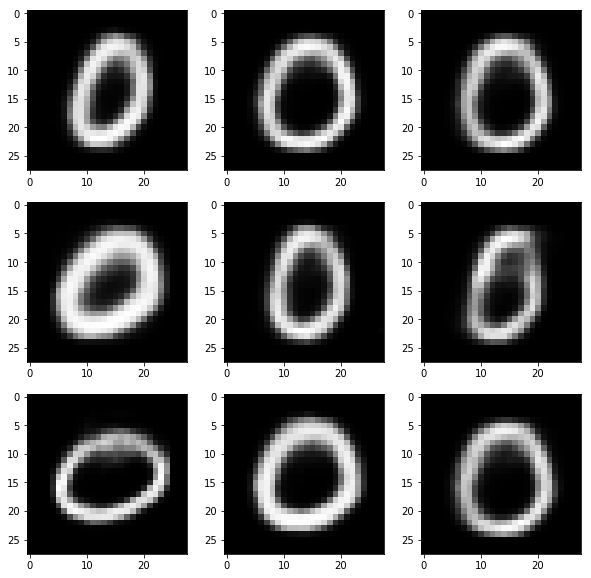

target domain 1135


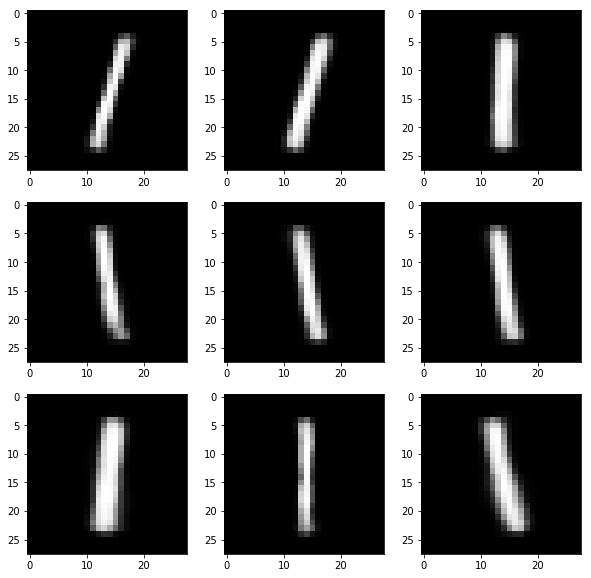

target domain 1032


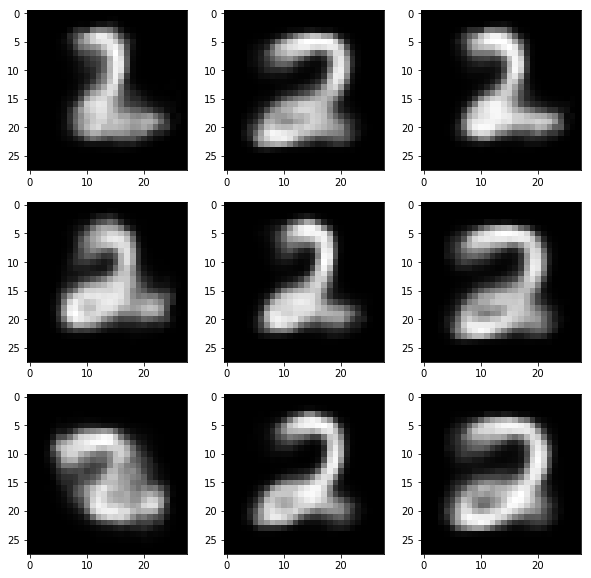

target domain 1010


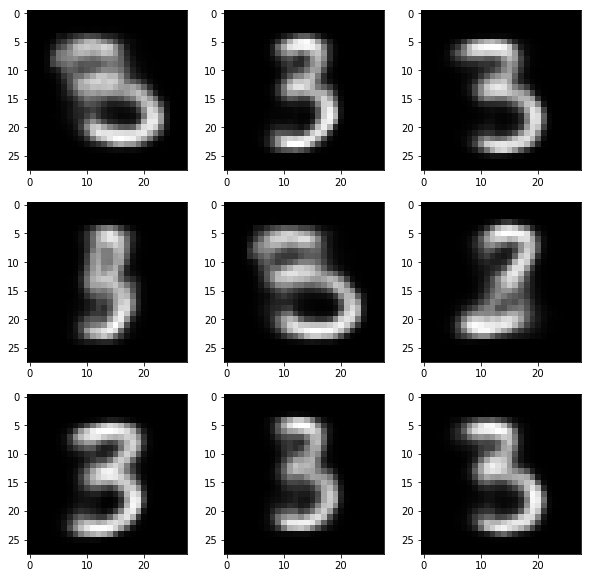

target domain 982


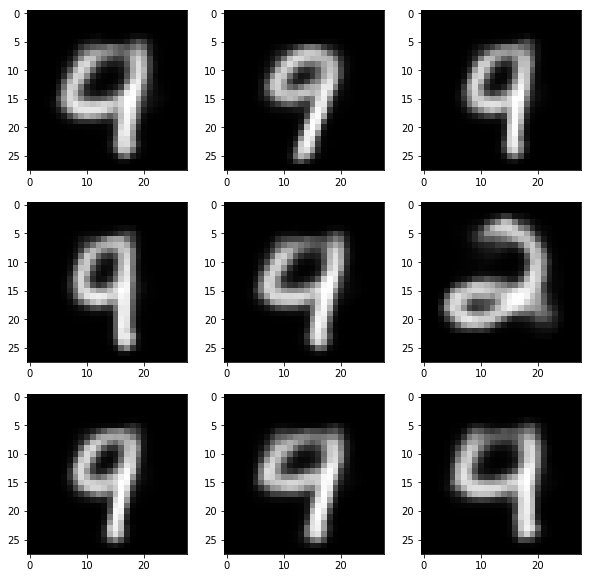

target domain 892


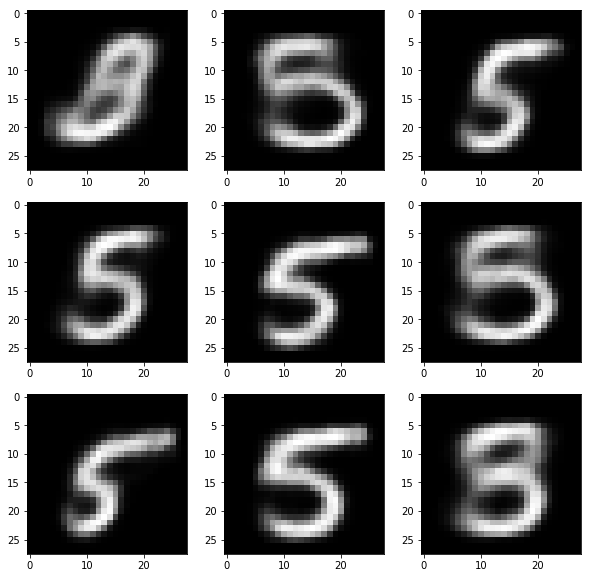

target domain 958


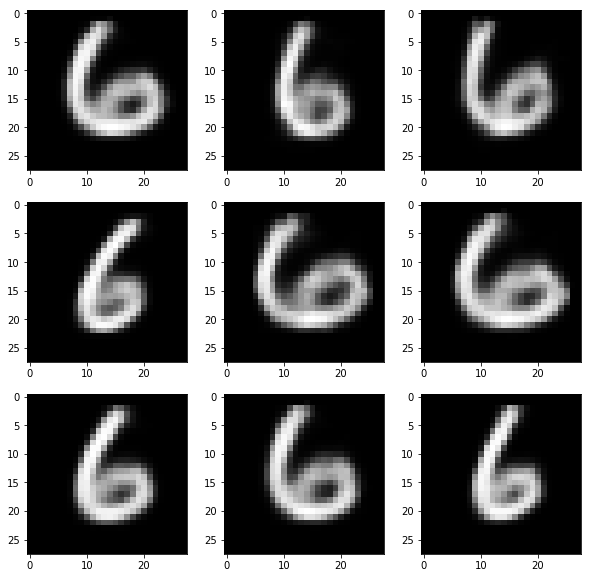

target domain 1028


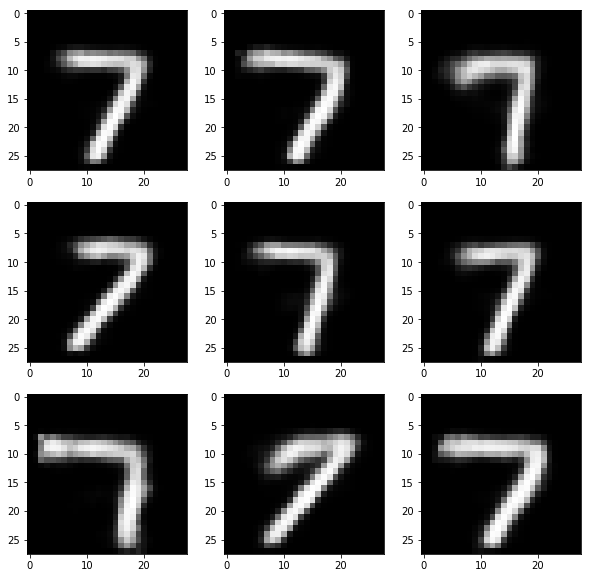

target domain 974


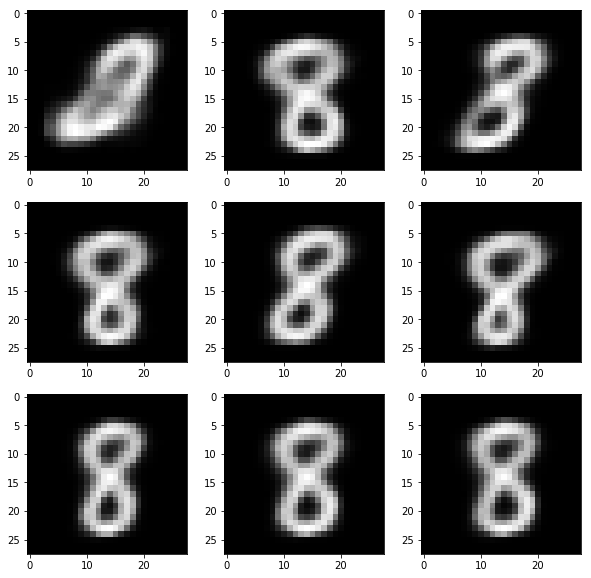

target domain 1009


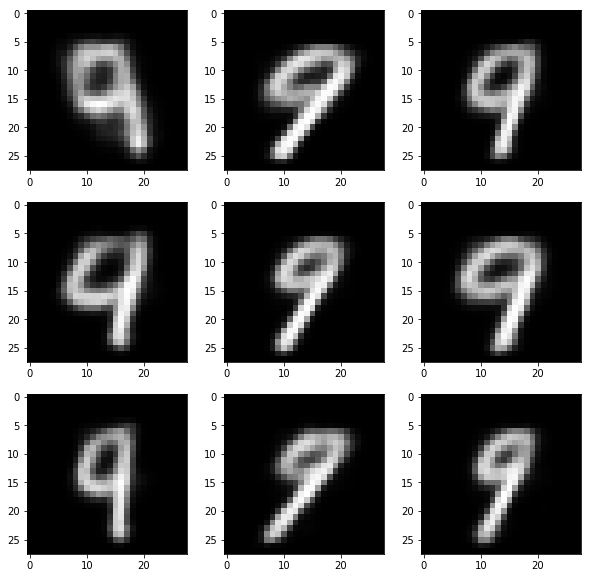

In [11]:
for choose_c in range(10):
    c=0
    for p in range(test_data.shape[0]):
        if np.argmax(test_labels[p])==choose_c:
            c+=1

    target_domain_size=c
    print('target domain',target_domain_size)

    k3=np.zeros([target_domain_size,784])
    c=0
    for p in range(test_data.shape[0]):
        if np.argmax(test_labels[p])==choose_c:
            k3[c]=test_data[p]
            c+=1

    c=0
    plt.figure(figsize=(10,10))
    for i in range(3):
        for j in range(3):
            x_PRR=k3[c].reshape([1,-1])
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
#             z_sample_=mu_ + sigma_ * np.random.normal(0.0,1.0,mu_.shape)
#             y_PMLR = sess.run(decoded, feed_dict={z_in: z_sample_.reshape([1,-1]), keep_prob : 1})
#             np.clip(y_PMLR,1e-8, 1 - 1e-8,out=y_PMLR)
            loc=''.join([str(3),str(3),str(c+1)])
            plt.subplot(eval(loc))
            plt.imshow(y_PRR.reshape([28,28]),cmap='gray')
            c+=1
    figpath=os.getcwd()+'/vae_simple_'+str(n_epochs)+'_'+str(dim_z)
    if not os.path.exists(figpath):
        os.system('mkdir '+figpath)
    plt.savefig(figpath+'/'+str(choose_c)+'.jpg')
    plt.show()


In [12]:
z_test = sess.run(z, feed_dict={x_hat: test_data, keep_prob : 1})
# z_sample_=mu_ + sigma_ * np.random.normal(0.0,1.0,mu_.shape)

In [13]:
z_test.shape

(10000, 3)

In [14]:
from sklearn.manifold import TSNE
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
z_embedded = TSNE(n_components=2).fit_transform(z_test)

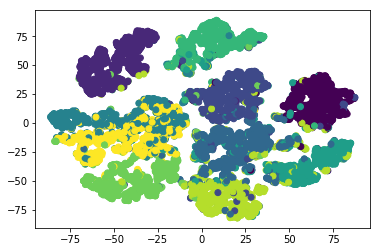

In [16]:
plt.scatter(z_embedded[:,0],z_embedded[:,1],c=10*np.argmax(test_labels,axis=1))